# a deep-learning classifier for subcellular localization of proteins

This example is inspired from : https://github.com/vanessajurtz/lasagne4bio/blob/master/subcellular_localization/notebook%20tutorial/FFN.ipynb

Based on the dataset from : https://academic.oup.com/bioinformatics/article/33/21/3387/3931857



## meet the data

In [16]:
from collections import defaultdict , Counter

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import pytorch_model_summary as pms 

from torch.utils.data import TensorDataset, DataLoader

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cpu device


In [2]:
# Load the encoded protein sequences, and labels 

train = np.load('data/subcellular_localization/reduced_train.npz')
X_train = train['X_train']
y_train = train['y_train']

print(X_train.shape)

(2423, 400, 20)


In [3]:
validation = np.load('data/subcellular_localization/reduced_val.npz')
X_valid = validation['X_val']
y_valid = validation['y_val']

print(X_valid.shape)

(635, 400, 20)


In [4]:
classes = ['Nucleus',
           'Cytoplasm',
           'Extracellular',
           'Mitochondrion',
           'Cell membrane',
           'ER',
           'Chloroplast',
           'Golgi apparatus',
           'Lysosome',
           'Vacuole']

dico_classes_subcell={i:v for i,v in enumerate(classes)}

for i in dico_classes_subcell.keys():
    print('Target', i, dico_classes_subcell[i])

Target 0 Nucleus
Target 1 Cytoplasm
Target 2 Extracellular
Target 3 Mitochondrion
Target 4 Cell membrane
Target 5 ER
Target 6 Chloroplast
Target 7 Golgi apparatus
Target 8 Lysosome
Target 9 Vacuole


Let's look at the target categories

<Axes: xlabel='count'>

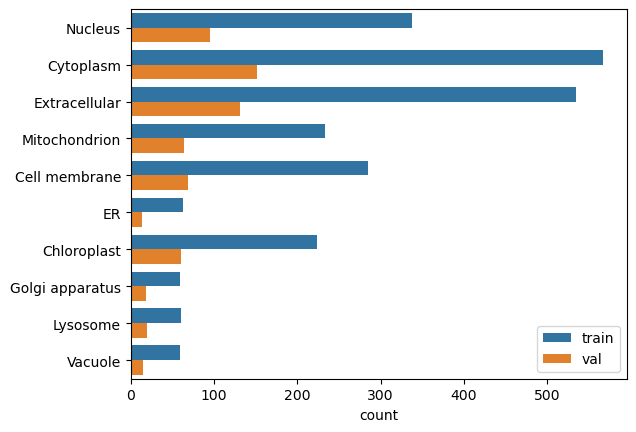

In [6]:
sns.countplot(y = [ dico_classes_subcell[y] for y in  y_train ] + [ dico_classes_subcell[y] for y in  y_valid ] ,
              hue = ['train']*len(y_train) + ['val']*len(y_valid),
              order = classes )

Each sequence is encoded as a matrix where each position is a row of size 20, for each possible amino-acid.

The values withing the matrix represent the amino acid frequency at the given position.

Naturally, on one hand the proteins have different sizes, but on the other our neural network will require a fixed input size, thus, each position after the last contains only zeroes.   

In [7]:
X_train[0,]

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

<Axes: >

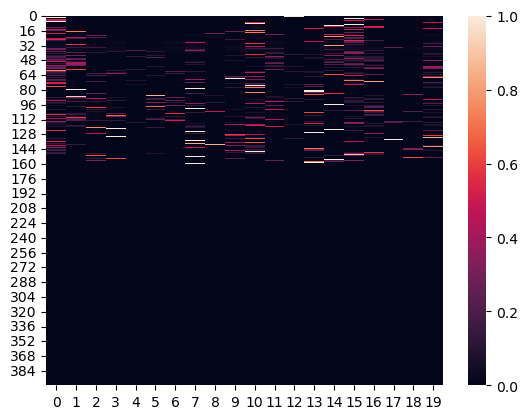

In [8]:
sns.heatmap( X_train[0,] )

## Thinking about the problem, the loss, and the constraints it poses

In the previous model we only had 2 classes in our target, thus our model output could merely be the probability  of belonging to class 1.
Furthermore, our loss function was `nn.BCELoss`, which stands in for **Binary** Cross Entropy.

However now our output target has 10 classes.

Thus our output will have to be different, and our loss function will have to be as well.


**exercise**: With the help of the [CEloss doc](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss), try to work out what the model output should be? how the target should be encoded? what parameters of the loss function may be of interest to us?



In [9]:
# help : https://pytorch.org/docs/stable/tensors.html
## this is how one can create a tensor of floats:

example = torch.DoubleTensor([1,2,3])
example

tensor([1., 2., 3.], dtype=torch.float64)

In [ ]:
CEloss = nn.CrossEntropyLoss()

pred = ...

target = ...

CEloss(pred , target)

---

correction:

making the loss work:

In [12]:
# %load -r 1-12 solutions/classifier_CEloss.py

additionnal considerations:

In [18]:
# %load -r 13-27 solutions/classifier_CEloss.py

In [19]:
# %load -r 28- solutions/classifier_CEloss.py

## build the data loaders

In [13]:
batch_size = 128

In [14]:
# transform to torch tensor
X_train_tensor = torch.Tensor(X_train) 
y_train_tensor = torch.LongTensor(y_train)

# create your dataset
train_dataset = TensorDataset(X_train_tensor,y_train_tensor) 

## creating a dataloader
train_dataloader = DataLoader(train_dataset , batch_size = batch_size ) 

In [15]:
# transform to torch tensor
X_valid_tensor = torch.Tensor(X_valid) 
y_valid_tensor = torch.LongTensor(y_valid)

# create your dataset
valid_dataset = TensorDataset(X_valid_tensor,y_valid_tensor) 

## creating a dataloader
valid_dataloader = DataLoader(valid_dataset , batch_size = batch_size )

## building a model

Architecture:
 - flatten
 - hidden layer
     - linear 
     - [dropout](https://ml-cheatsheet.readthedocs.io/en/latest/regularization.html?highlight=dropout#dropout)
     - ReLu activation
 - output layer 
     - linear 
     
sizes:
 - input size = 8000
 - hidden size = [80]
 - output size = number of classes = 10


In [16]:

class ProteinLoc_neuralNet(torch.nn.Module):
    
    def __init__(self , input_dim = 8000 , 
                         hidden_dim=[80] ,
                         output_dim = 10 , 
                         dropout_fraction = 0.25):
        super().__init__()
        
        ## we transform the input from 2D to 1D
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(  )
        
        # each layer is made of a linear layer with a ReLu activation and a DropOut Layer
        for i in range(len(hidden_dim)):
            
            self.layers.append( nn.Linear(input_dim, hidden_dim[i]) )
            self.layers.append( nn.ReLU() )
            self.layers.append( nn.Dropout(dropout_fraction) )
            
            input_dim = hidden_dim[i] ## update the input dimension for the next layer
        
        self.layers.append( nn.Linear(input_dim, output_dim) )
        
    def forward(self, x):
        x = self.flatten(x)
        ## NB: here, the output of the last layer are logits
        logits = self.layers(x)
        return logits


model = ProteinLoc_neuralNet().to(device)
print(model)

ProteinLoc_neuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=8000, out_features=80, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=80, out_features=10, bias=True)
  )
)


In [17]:
print(pms.summary(model, torch.zeros(1,400,20), show_input=True))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
         Flatten-1        [1, 400, 20]               0               0
          Linear-2           [1, 8000]         640,080         640,080
            ReLU-3             [1, 80]               0               0
         Dropout-4             [1, 80]               0               0
          Linear-5             [1, 80]             810             810
Total params: 640,890
Trainable params: 640,890
Non-trainable params: 0
-----------------------------------------------------------------------


As we did before, playing a bit with the model cannot hurt : 

In [28]:

model.eval()
x, y = valid_dataset[:5] ## let's go with a batch of 5 samples

with torch.no_grad(): ## disables tracking of gradient: prevent accidental training + speeds up computation
    x = x.to(device)
    pred = model(x)
    predicted, actual = pred[0], y
    print(f'Predicted proba: "{predicted}", Actual: "{actual}"')

Predicted proba: "tensor([ 0.0428, -0.0054,  0.0134,  0.0231, -0.0149,  0.1216,  0.0212,  0.0321,
         0.0346,  0.0454])", Actual: "tensor([6, 6, 2, 3, 3])"


In [29]:
y

tensor([6, 6, 2, 3, 3])

In [33]:
pred

tensor([[ 0.0428, -0.0054,  0.0134,  0.0231, -0.0149,  0.1216,  0.0212,  0.0321,
          0.0346,  0.0454],
        [ 0.0198,  0.0119,  0.0214,  0.0061, -0.0071,  0.0847,  0.0591,  0.0360,
          0.0386,  0.0165],
        [ 0.0438, -0.0197, -0.0071,  0.0247, -0.0308,  0.0823,  0.0336,  0.0629,
          0.0748,  0.0194],
        [ 0.0218, -0.0091,  0.0109,  0.0191, -0.0388,  0.1125,  0.0388,  0.0639,
          0.0538,  0.0176],
        [ 0.0726,  0.0036,  0.0837,  0.0195, -0.0480,  0.1335,  0.0340,  0.0228,
          0.0202,  0.0436]])

In [36]:
## from "logits" to probabilities
nn.Softmax()( pred )

/tmp/ipykernel_529376/3892603398.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  nn.Softmax()( pred )


tensor([[0.1011, 0.0963, 0.0982, 0.0991, 0.0954, 0.1094, 0.0989, 0.1000, 0.1003,
         0.1013],
        [0.0991, 0.0983, 0.0992, 0.0977, 0.0965, 0.1057, 0.1031, 0.1007, 0.1010,
         0.0988],
        [0.1015, 0.0952, 0.0964, 0.0996, 0.0942, 0.1055, 0.1005, 0.1034, 0.1047,
         0.0990],
        [0.0992, 0.0962, 0.0981, 0.0989, 0.0934, 0.1086, 0.1009, 0.1035, 0.1024,
         0.0988],
        [0.1034, 0.0965, 0.1045, 0.0980, 0.0916, 0.1098, 0.0994, 0.0983, 0.0981,
         0.1004]])

In [32]:
## getting the predicted category as the one with the highest score
np.argmax(pred.detach(), axis = 1)

tensor([5, 5, 5, 5, 5])

In [37]:
CEloss(pred,y)

tensor(10.8409)

Now we can be reassured that our model does take the data as input, and output something we can compute a score on.

### defining training/validation functions

Our cross entropy loss is all good and well, but it would be nice to be able to compute additionnal metrics while we train.

Let's adapt our training function to reflect this

 * [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)
 * [balanced_accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html#sklearn.metrics.balanced_accuracy_score)
 * [F1_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score)

In [68]:
from sklearn import metrics


def get_additional_scores( predicted , target ):
        
    return { 'balanced_accuracy' : metrics.balanced_accuracy_score( target , predicted ),
             'accuracy' : metrics.accuracy_score( target , predicted ),
             'f1' : metrics.f1_score( target , predicted ,
                                     average = 'macro' ) }



get_additional_scores( np.argmax(pred.detach().numpy(),axis=1) , y.numpy() )

/home/wandrille/Installed_software/anaconda3/envs/pytorch_course/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


{'balanced_accuracy': 0.0, 'accuracy': 0.0, 'f1': 0.0}

In [69]:
def train(dataloader, model, loss_fn, optimizer , additional_score_function , echo = True , echo_batch = False):
    
    size = len(dataloader.dataset) # how many batches do we have
    model.train() #     Sets the module in training mode.
    
    ## we will keep prediction and target on the whole dataset
    all_predictions = []
    all_targets = []
    
    for batch, (X, y) in enumerate(dataloader): # for each batch
        X, y = X.to(device), y.to(device) # send the data to the GPU or whatever device you use for training

        # Compute prediction error
        pred = model(X)              # prediction for the model -> forward pass
        loss = loss_fn(pred, y)      # loss function from these prediction

        ## accumulate prediction and target on the whole dataset
        all_predictions.extend( np.argmax(pred.detach().numpy() , axis=1) )
        all_targets.extend( y.numpy() )
        
        
        # Backpropagation
        loss.backward()              # backward propagation 
        #                            https://ml-cheatsheet.readthedocs.io/en/latest/backpropagation.html
        #                            https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html
        
        optimizer.step()             
        optimizer.zero_grad()        # reset the gradients
                                     # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch

        if echo_batch:
            current =  (batch + 1) * len(X)
            print(f"Train loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")
    
    if echo:
        current =  (batch + 1) * len(X)
        print(f"Train loss: {loss.item():>7f}")

    
    # return the last batch loss, as well as the metrics computed on all batches
    scores = additional_score_function( all_predictions , all_targets )
    scores['loss'] = loss.item()
    return scores



In [70]:
def valid(dataloader, model, loss_fn, additional_score_function, echo = True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() #     Sets the module in evaluation mode
    
    ## we will keep prediction and target on the whole dataset
    all_predictions = []
    all_targets = []
    
    valid_loss = 0
    with torch.no_grad(): ## disables tracking of gradient: prevent accidental training + speeds up computation
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            valid_loss += loss_fn(pred, y).item()  ## accumulating the loss function over the batches
            
            ## accumulate prediction and target on the whole dataset
            all_predictions.extend( np.argmax(pred.detach().numpy() , axis=1) )
            all_targets.extend( y.numpy() )

            
    valid_loss /= num_batches

    if echo:
        print(f"\tValid loss: {valid_loss:>8f}")
    ## return the average loss / batch
    scores = additional_score_function( all_predictions , all_targets )
    scores['loss'] = valid_loss
    return  scores


## training the model

Our optimizer will be [ADAM](https://ml-cheatsheet.readthedocs.io/en/latest/optimizers.html#adam)

In [115]:
## preamble -> define the model, the loss function, and the optimizer
model = ProteinLoc_neuralNet(input_dim = 8000 , 
                             hidden_dim=[80] ,
                             output_dim = 10 , 
                             dropout_fraction = 0.1).to(device)


W = torch.Tensor( compute_class_weight(class_weight='balanced' , 
                     classes = range(10) , 
                     y= y_train) )

CEloss = nn.CrossEntropyLoss(weight = W)
print('weights_classes',W.numpy())


optimizer = torch.optim.Adam(model.parameters(), 
                       lr = 10**-4,
                       weight_decay = 10**-2)


## container to keep the scores across all epochs
train_scores = defaultdict(list)
valid_scores = defaultdict(list)


weights_classes [0.71686393 0.42733687 0.4528972  1.0399141  0.85017544 3.8460317
 1.0816964  4.1067796  4.0383334  4.1067796 ]


In [119]:
%%time
## lets do a single round, to learn how long it takes
tmp_scores = train(train_dataloader, 
                   model, 
                   CEloss, 
                   optimizer, 
                   get_additional_scores , 
                   echo = True , echo_batch = True )
for k in tmp_scores:
    train_scores[k].append( tmp_scores[k] )



tmp_scores = valid(valid_dataloader, 
                   model, 
                   CEloss , 
                   get_additional_scores ,
                   echo = True)
for k in tmp_scores:
    valid_scores[k].append( tmp_scores[k] )


Train loss: 0.726278  [  128/ 2423]
Train loss: 0.865607  [  256/ 2423]
Train loss: 0.764671  [  384/ 2423]
Train loss: 0.839189  [  512/ 2423]
Train loss: 0.759815  [  640/ 2423]
Train loss: 0.724492  [  768/ 2423]
Train loss: 0.759459  [  896/ 2423]
Train loss: 0.625411  [ 1024/ 2423]
Train loss: 0.692794  [ 1152/ 2423]
Train loss: 0.654630  [ 1280/ 2423]
Train loss: 0.778166  [ 1408/ 2423]
Train loss: 0.657839  [ 1536/ 2423]
Train loss: 0.764883  [ 1664/ 2423]
Train loss: 0.831054  [ 1792/ 2423]
Train loss: 0.662275  [ 1920/ 2423]
Train loss: 0.712358  [ 2048/ 2423]
Train loss: 0.804935  [ 2176/ 2423]
Train loss: 0.666013  [ 2304/ 2423]
Train loss: 0.606997  [ 2261/ 2423]
Train loss: 0.606997
	Valid loss: 1.392075
CPU times: user 773 ms, sys: 19.7 ms, total: 793 ms
Wall time: 202 ms


From there, we can deduce approximately how much time training for 50, 100, or 500 epoch will take.

Here: 192ms x 100 = 19.2s

In [120]:
%%time
epochs = 100


for t in range(1,epochs+1):

    echo = t%10==0
    if echo:
        print('Epoch',t )    
    
    tmp_scores = train(train_dataloader, 
                       model, 
                       CEloss, 
                       optimizer, 
                       get_additional_scores , 
                       echo= echo , echo_batch=False )
    for k in tmp_scores:
        train_scores[k].append( tmp_scores[k] )



    tmp_scores = valid(valid_dataloader, 
                       model, 
                       CEloss , 
                       get_additional_scores ,
                       echo = echo)
    for k in tmp_scores:
        valid_scores[k].append( tmp_scores[k] )
print("Done!")

Epoch 10
Train loss: 0.520517
	Valid loss: 1.332558
Epoch 20
Train loss: 0.466411
	Valid loss: 1.291289
Epoch 30
Train loss: 0.417297
	Valid loss: 1.260933
Epoch 40
Train loss: 0.392655
	Valid loss: 1.237024
Epoch 50
Train loss: 0.341419
	Valid loss: 1.217165
Epoch 60
Train loss: 0.326372
	Valid loss: 1.202846
Epoch 70
Train loss: 0.310532
	Valid loss: 1.191986
Epoch 80
Train loss: 0.293877
	Valid loss: 1.177134
Epoch 90
Train loss: 0.272712
	Valid loss: 1.171014
Epoch 100
Train loss: 0.272058
	Valid loss: 1.159016
Done!
CPU times: user 1min 2s, sys: 440 ms, total: 1min 2s
Wall time: 15.7 s


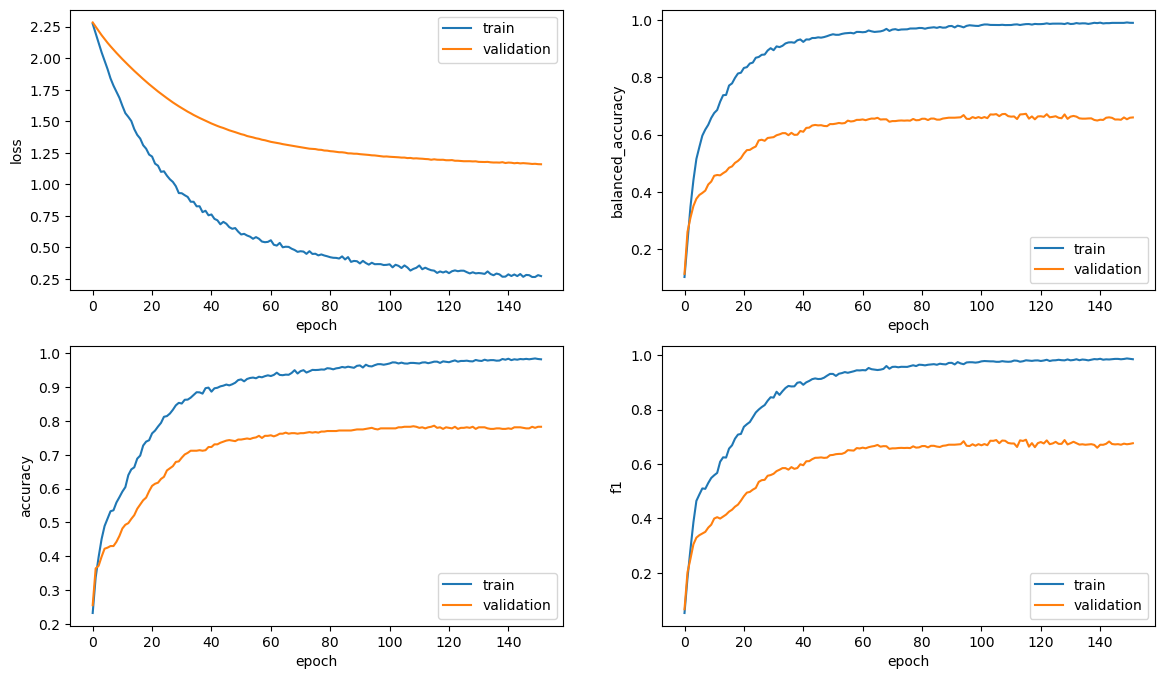

In [122]:
fig, axes = plt.subplots(2,2,figsize = (14,8))    


for i,k in enumerate( ['loss', 'balanced_accuracy', 'accuracy', 'f1'] ) :

    axes[i//2][i%2].plot(train_scores[k] , label = 'train')
    axes[i//2][i%2].plot(valid_scores[k], label = 'validation')
    axes[i//2][i%2].legend()
    axes[i//2][i%2].set_xlabel('epoch')
    axes[i//2][i%2].set_ylabel(k)

Should we stop here ? Go for another 100 epochs? 500 epochs?

We could use a [early stopping](https://ml-cheatsheet.readthedocs.io/en/latest/regularization.html?highlight=dropout#early-stopping) mechanism, which stops iteration when the validation loss has not increased for `X` epochs (or when it has not improved by at least a given amount).

This can be particularly important in cases where your model starts to grossly overfit the training data.

For an implementation example, you can look up this [early stopping demo on MNIST](https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb), which we will use in the next notebooks

Text(0.5, 23.52222222222222, 'Predicted label')

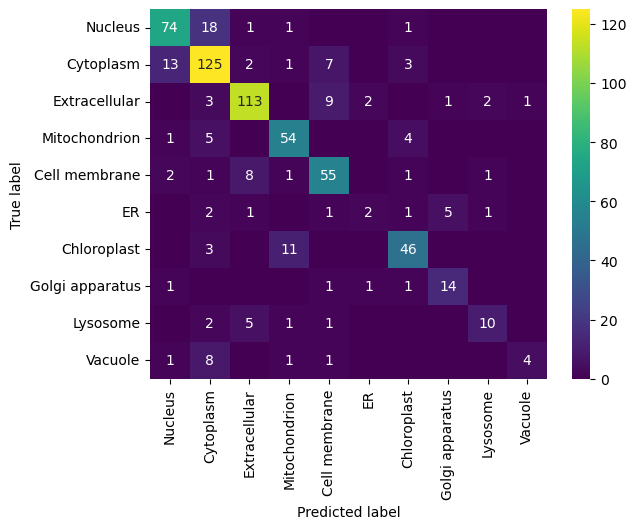

In [173]:
import pandas as pd
import seaborn as sns

y_pred = model(X_valid_tensor)
y_pred = np.argmax(y_pred.detach().numpy(), axis=1)

df = pd.crosstab( y_valid  , y_pred , rownames=['truth'] , colnames=['prediction'])
df.columns = classes
df.index = classes

# simple heatmap
#sns.heatmap(df , annot = True , fmt='.0f', cmap = 'viridis')

#trick to make the 0s dissapear
sns.heatmap(df , annot = df.astype(str).replace('0','') , fmt ='s' , cmap = 'viridis')
plt.ylabel('True label')
plt.xlabel('Predicted label')


---

## playground

what follows is just us playing around wit some code

### effect of drop-out fraction

In [82]:

def train_ProteinLoc_neuralNet( DO , epochs , model = None , CEloss=None, optimizer=None ):
    
    if model is None:
        ## preamble -> define the model, the loss function, and the optimizer
        model = ProteinLoc_neuralNet(input_dim = 8000 , 
                                     hidden_dim=[80] ,
                                     output_dim = 10 , 
                                     dropout_fraction = DO).to(device)


        W = torch.Tensor( compute_class_weight(class_weight='balanced' , 
                             classes = range(10) , 
                             y= y_train) )

        CEloss = nn.CrossEntropyLoss(weight = W)


        optimizer = torch.optim.Adam(model.parameters(), 
                               lr = 10**-4,
                               weight_decay = 10**-2)


    ## container to keep the scores across all epochs
    train_scores = defaultdict(list)
    valid_scores = defaultdict(list)

    for t in range(1,epochs+1):

        tmp_scores = train(train_dataloader, 
                           model, 
                           CEloss, 
                           optimizer, 
                           get_additional_scores , 
                           echo= False , echo_batch=False )
        for k in tmp_scores:
            train_scores[k].append( tmp_scores[k] )

        tmp_scores = valid(valid_dataloader, 
                           model, 
                           CEloss , 
                           get_additional_scores ,
                           echo = False)
        for k in tmp_scores:
            valid_scores[k].append( tmp_scores[k] )
        
    return train_scores,valid_scores , model, CEloss,optimizer 

In [94]:
%%time
results_dict = {'loss' :[], 'epoch':[],'drop_out':[], 'train_valid':[]}

E=300
for DO in np.arange(0,0.5,0.1):

    train_scores,valid_scores ,_,_,_ = train_ProteinLoc_neuralNet( DO=DO , epochs=E)

    results_dict['loss'].extend( train_scores['loss'] )
    results_dict['epoch'].extend( range(1,E+1) )
    results_dict['drop_out'].extend( [DO]*E )
    results_dict['train_valid'].extend( ['train']*E )

    results_dict['loss'].extend( valid_scores['loss'] )
    results_dict['epoch'].extend( range(1,E+1) )
    results_dict['drop_out'].extend( [DO]*E )
    results_dict['train_valid'].extend( ['valid']*E )


weights_classes [0.71686393 0.42733687 0.4528972  1.0399141  0.85017544 3.8460317
 1.0816964  4.1067796  4.0383334  4.1067796 ]
weights_classes [0.71686393 0.42733687 0.4528972  1.0399141  0.85017544 3.8460317
 1.0816964  4.1067796  4.0383334  4.1067796 ]
weights_classes [0.71686393 0.42733687 0.4528972  1.0399141  0.85017544 3.8460317
 1.0816964  4.1067796  4.0383334  4.1067796 ]
weights_classes [0.71686393 0.42733687 0.4528972  1.0399141  0.85017544 3.8460317
 1.0816964  4.1067796  4.0383334  4.1067796 ]
weights_classes [0.71686393 0.42733687 0.4528972  1.0399141  0.85017544 3.8460317
 1.0816964  4.1067796  4.0383334  4.1067796 ]
weights_classes [0.71686393 0.42733687 0.4528972  1.0399141  0.85017544 3.8460317
 1.0816964  4.1067796  4.0383334  4.1067796 ]
weights_classes [0.71686393 0.42733687 0.4528972  1.0399141  0.85017544 3.8460317
 1.0816964  4.1067796  4.0383334  4.1067796 ]
weights_classes [0.71686393 0.42733687 0.4528972  1.0399141  0.85017544 3.8460317
 1.0816964  4.1067796 

<Axes: xlabel='epoch', ylabel='loss'>

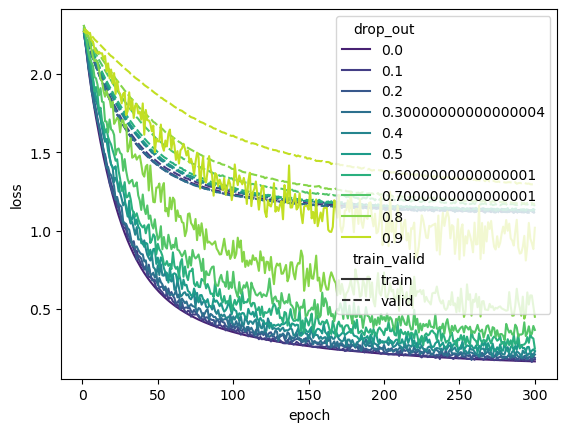

In [95]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(results_dict)
df.drop_out = df.drop_out.astype(str)
sns.lineplot( df , x='epoch' , y='loss' , hue = 'drop_out' , style = 'train_valid' , palette='viridis' )

<Axes: xlabel='epoch', ylabel='loss'>

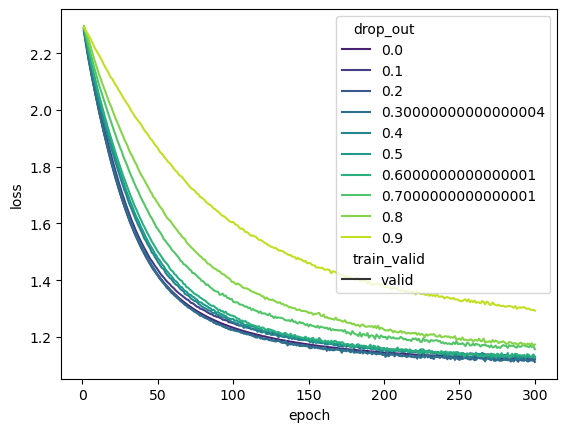

In [96]:
sns.lineplot( df.loc[df.train_valid=='valid',:] , x='epoch' , y='loss' , hue = 'drop_out' , style = 'train_valid' , palette='viridis' )

### one more layer

In [133]:
## preamble -> define the model, the loss function, and the optimizer
model2 = ProteinLoc_neuralNet(input_dim = 8000 , 
                             hidden_dim=[160,80,40,20] ,
                             output_dim = 10 , 
                             dropout_fraction = 0.1).to(device)


W = torch.Tensor( compute_class_weight(class_weight='balanced' , 
                     classes = range(10) , 
                     y= y_train) )

CEloss = nn.CrossEntropyLoss(weight = W)
print('weights_classes',W.numpy())


optimizer = torch.optim.Adam(model2.parameters(), 
                       lr = 10**-5,
                       weight_decay = 10**-2)


## container to keep the scores across all epochs
train_scores2 = defaultdict(list)
valid_scores2 = defaultdict(list)


weights_classes [0.71686393 0.42733687 0.4528972  1.0399141  0.85017544 3.8460317
 1.0816964  4.1067796  4.0383334  4.1067796 ]


Epoch 10
Train loss: 2.088246
	Valid loss: 2.195845
Epoch 20
Train loss: 2.047161
	Valid loss: 2.173629
Epoch 30
Train loss: 1.983433
	Valid loss: 2.150078
Epoch 40
Train loss: 1.953356
	Valid loss: 2.126192
Epoch 50
Train loss: 1.894814
	Valid loss: 2.101910
Epoch 60
Train loss: 1.838175
	Valid loss: 2.078742
Epoch 70
Train loss: 1.849097
	Valid loss: 2.057343
Epoch 80
Train loss: 1.765285
	Valid loss: 2.037945
Epoch 90
Train loss: 1.699910
	Valid loss: 2.019851
Epoch 100
Train loss: 1.686530
	Valid loss: 2.004416
Epoch 110
Train loss: 1.639084
	Valid loss: 1.988904
Epoch 120
Train loss: 1.617923
	Valid loss: 1.976529
Epoch 130
Train loss: 1.584683
	Valid loss: 1.965013
Epoch 140
Train loss: 1.537081
	Valid loss: 1.953721
Epoch 150
Train loss: 1.529623
	Valid loss: 1.941687
Epoch 160
Train loss: 1.520129
	Valid loss: 1.934482
Epoch 170
Train loss: 1.471973
	Valid loss: 1.927275
Epoch 180
Train loss: 1.367008
	Valid loss: 1.917738
Epoch 190
Train loss: 1.456576
	Valid loss: 1.911527
Ep

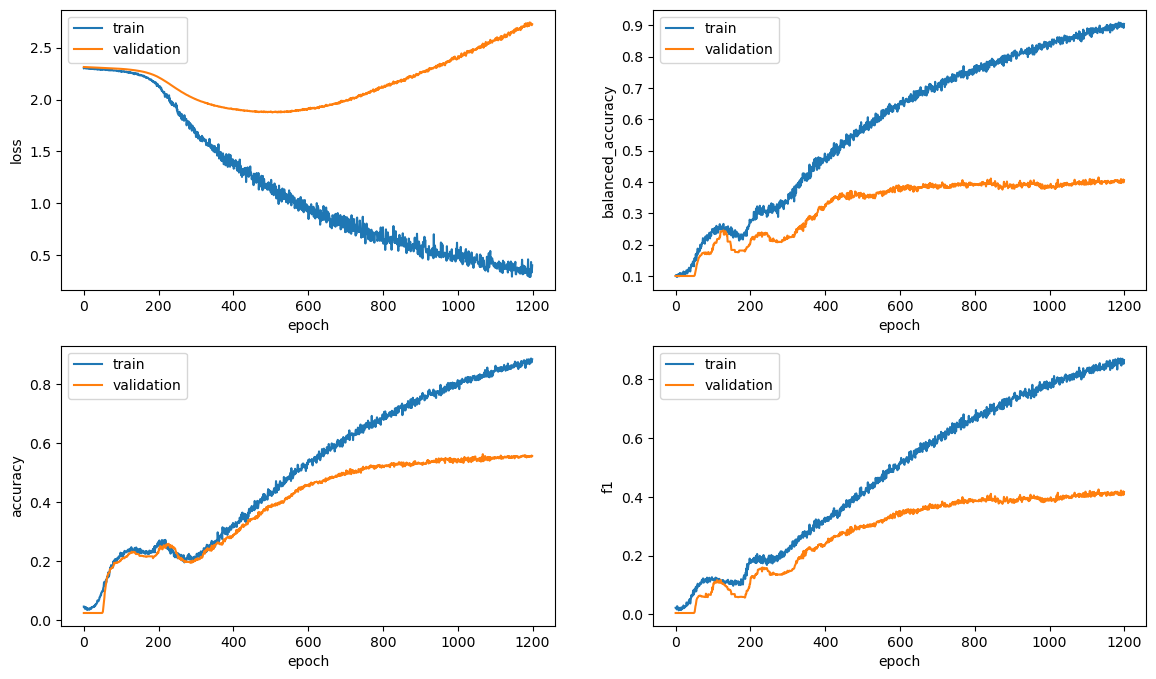

In [136]:
%%time
epochs = 1000


for t in range(1,epochs+1):

    echo = t%10==0
    if echo:
        print('Epoch',t )    
    
    tmp_scores = train(train_dataloader, 
                       model2, 
                       CEloss, 
                       optimizer, 
                       get_additional_scores , 
                       echo= echo , echo_batch=False )
    for k in tmp_scores:
        train_scores2[k].append( tmp_scores[k] )



    tmp_scores = valid(valid_dataloader, 
                       model2, 
                       CEloss , 
                       get_additional_scores ,
                       echo = echo)
    for k in tmp_scores:
        valid_scores2[k].append( tmp_scores[k] )
print("Done!")
fig, axes = plt.subplots(2,2,figsize = (14,8))    


for i,k in enumerate( ['loss', 'balanced_accuracy', 'accuracy', 'f1'] ) :

    axes[i//2][i%2].plot(train_scores2[k] , label = 'train')
    axes[i//2][i%2].plot(valid_scores2[k], label = 'validation')
    axes[i//2][i%2].legend()
    axes[i//2][i%2].set_xlabel('epoch')
    axes[i//2][i%2].set_ylabel(k)

In [137]:
valid_scores2['accuracy'][-1] , valid_scores['accuracy'][-1]

(0.5559055118110237, 0.7826771653543307)

In [138]:

class ProteinLoc_neuralNet_ELU(torch.nn.Module):
    
    def __init__(self , input_dim = 8000 , 
                         hidden_dim=[80] ,
                         output_dim = 10 , 
                         dropout_fraction = 0.25):
        super().__init__()
        
        ## we transform the input from 2D to 1D
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(  )
        
        # each layer is made of a linear layer with a ReLu activation and a DropOut Layer
        for i in range(len(hidden_dim)):
            
            self.layers.append( nn.Linear(input_dim, hidden_dim[i]) )
            self.layers.append( nn.ELU(1.0) )
            self.layers.append( nn.Dropout(dropout_fraction) )
            
            input_dim = hidden_dim[i] ## update the input dimension for the next layer
        
        self.layers.append( nn.Linear(input_dim, output_dim) )
        
    def forward(self, x):
        x = self.flatten(x)
        ## NB: here, the output of the last layer are logits
        logits = self.layers(x)
        return logits




In [139]:
## preamble -> define the model, the loss function, and the optimizer
model3 = ProteinLoc_neuralNet_ELU(input_dim = 8000 , 
                             hidden_dim=[80] ,
                             output_dim = 10 , 
                             dropout_fraction = 0.1).to(device)


W = torch.Tensor( compute_class_weight(class_weight='balanced' , 
                     classes = range(10) , 
                     y= y_train) )

CEloss = nn.CrossEntropyLoss(weight = W)
print('weights_classes',W.numpy())


optimizer = torch.optim.Adam(model3.parameters(), 
                       lr = 10**-4,
                       weight_decay = 10**-2)


## container to keep the scores across all epochs
train_scores3 = defaultdict(list)
valid_scores3 = defaultdict(list)


weights_classes [0.71686393 0.42733687 0.4528972  1.0399141  0.85017544 3.8460317
 1.0816964  4.1067796  4.0383334  4.1067796 ]


Epoch 10
Train loss: 0.300682
	Valid loss: 1.187573
Epoch 20
Train loss: 0.259918
	Valid loss: 1.174414
Epoch 30
Train loss: 0.243976
	Valid loss: 1.165972
Epoch 40
Train loss: 0.231526
	Valid loss: 1.157749
Epoch 50
Train loss: 0.223372
	Valid loss: 1.155127
Epoch 60
Train loss: 0.212808
	Valid loss: 1.149503
Epoch 70
Train loss: 0.211860
	Valid loss: 1.143349
Epoch 80
Train loss: 0.200966
	Valid loss: 1.138217
Epoch 90
Train loss: 0.193319
	Valid loss: 1.138188
Epoch 100
Train loss: 0.187559
	Valid loss: 1.132351
Done!
CPU times: user 1min 4s, sys: 544 ms, total: 1min 4s
Wall time: 16.2 s


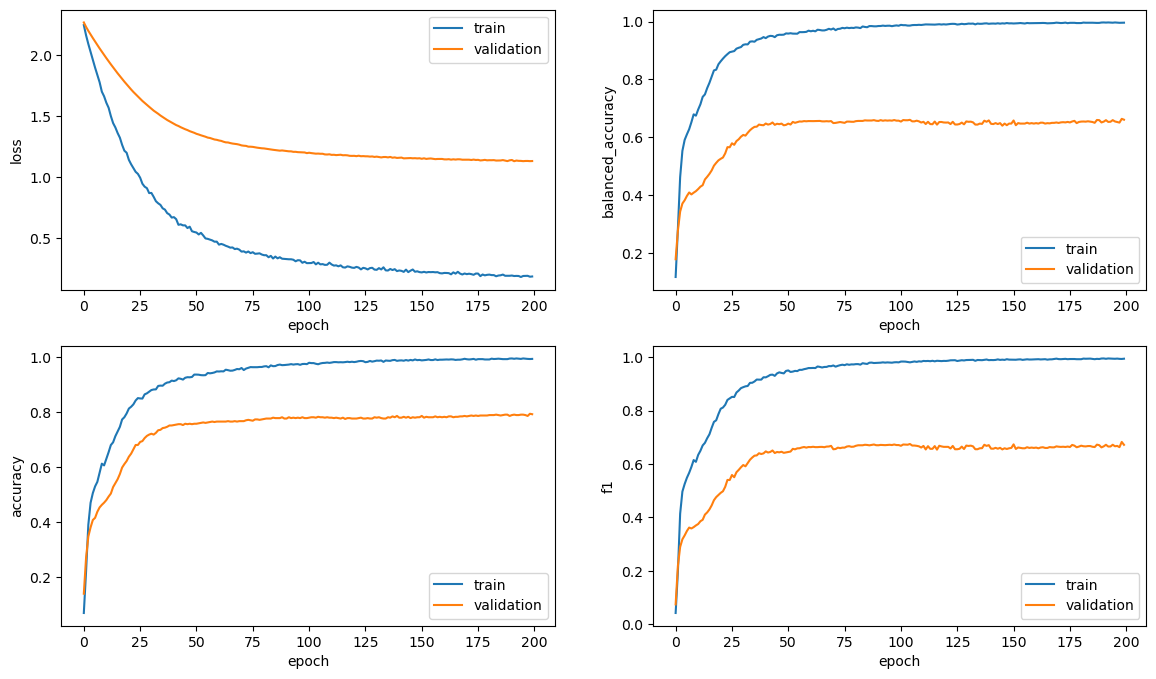

In [141]:
%%time
epochs = 100


for t in range(1,epochs+1):

    echo = t%10==0
    if echo:
        print('Epoch',t )    
    
    tmp_scores = train(train_dataloader, 
                       model3, 
                       CEloss, 
                       optimizer, 
                       get_additional_scores , 
                       echo= echo , echo_batch=False )
    for k in tmp_scores:
        train_scores3[k].append( tmp_scores[k] )



    tmp_scores = valid(valid_dataloader, 
                       model3, 
                       CEloss , 
                       get_additional_scores ,
                       echo = echo)
    for k in tmp_scores:
        valid_scores3[k].append( tmp_scores[k] )
print("Done!")
fig, axes = plt.subplots(2,2,figsize = (14,8))    


for i,k in enumerate( ['loss', 'balanced_accuracy', 'accuracy', 'f1'] ) :

    axes[i//2][i%2].plot(train_scores3[k] , label = 'train')
    axes[i//2][i%2].plot(valid_scores3[k], label = 'validation')
    axes[i//2][i%2].legend()
    axes[i//2][i%2].set_xlabel('epoch')
    axes[i//2][i%2].set_ylabel(k)

In [143]:
valid_scores3['loss'][-1] , valid_scores2['loss'][-1] , valid_scores['loss'][-1]

(1.1323513746261598, 2.7242886066436767, 1.1590163707733154)